# TF IS A GCN

In [114]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## Graph Convolution

In [115]:
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphConvolution, self).__init__()

        # number of input features for each node
        self.in_features = in_features 

        # number of output features for each node after convolution
        self.out_features = out_features 

        # learnable weights matrix of shape (in_features, out_features) used for
        # linear transformation of input features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features)) 

        # learnable bias vector of shape (out_features) added to output of
        # convolution
        self.bias = nn.Parameter(torch.FloatTensor(out_features))
        
        # initialize weights and bias
        self.reset_parameters()

    def reset_parameters(self):
        #initialize weight matrix using the Xavier uniform initialization (TODO: why?)
        nn.init.xavier_uniform_(self.weight)

        #initialize bias vector to zeros
        nn.init.zeros_(self.bias)

    def forward(self, input, adj):
        # input: input features of shape (num_nodes, in_features)
        # adj: adjacency matrix of shape (num_nodes, num_nodes)
        # output: covolutional features of shape (num_nodes, out_features)

        # linear transformation of input features using weight matrix, output shape: (num_nodes, out_features)
        support = torch.mm(input, self.weight)

        # support tensor is multiplied by adjacency matrix.
        # propagates the transformed features across the graph structure,
        # allowing each node to receive/aggregate information from neighbors     
        output = torch.mm(adj, support)

        # add bias to output
        return output + self.bias

The crucial part of the GraphConvolution layer is **output = torch.mm(adj, support)**. 

This operation can be understood as follows:

- For each node i, we take the i-th row of the adjacency matrix adj[i]. This row represents the connections between node i and its neighbors.
- We multiply this row adj[i] with the support tensor, which contains the transformed features of all nodes.

This multiplication effectively takes a weighted sum of the transformed features of node i and its neighbors, where the weights are determined by the adjacency matrix entries.

The result is a new feature vector for node i, which incorporates information from its neighbors' features as well as its own features.

By applying this operation to all nodes in the graph, the GraphConvolution layer allows information to propagate and be aggregated across the graph structure, enabling the model to learn representations that capture the graph's structural information.

## Adjacency matrix

The adjacency matrix is a way to represent the connections or edges between nodes. It is a square matrix where the rows and columns correspond to the nodes in the graph.

For an undirected graph with `N` nodes, the adjacency matrix `adj` has the following properties:

- `adj` is an `N x N` matrix.
- `adj[i, j]` represents the connection between node `i` and node `j`.
- If there is an edge between node `i` and node `j`, then `adj[i, j] = adj[j, i] = 1`. Otherwise, `adj[i, j] = adj[j, i] = 0`.
- The diagonal elements `adj[i, i]` are typically set to 0, as there are no self-connections in an undirected graph.

For a weighted graph, the non-zero entries in the adjacency matrix represent the weights of the edges instead of just binary values.

Here's a simple example to illustrate the adjacency matrix:

Consider a graph with 5 nodes, where the edges are (0, 1), (1, 2), (2, 3), (3, 4), and (0, 4). The corresponding adjacency matrix would be:

```txt
adj = [[0, 1, 0, 0, 1],
       [1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0],
       [0, 0, 1, 0, 1],
       [1, 0, 0, 1, 0]]
```


When performing the graph convolution operation `output = torch.mm(adj, support)` in the `GraphConvolution` layer, the adjacency matrix `adj` determines how the transformed features (`support`) of each node are aggregated from its neighbors.

For example, if we consider node 0, the corresponding row in the adjacency matrix is `adj[0] = [0, 1, 0, 0, 1]`. This means that when computing the output features for node 0, the transformed features of nodes 1 and 4 will be aggregated (weighted by the adjacency matrix entries), while the features of nodes 2 and 3 will be ignored since there are no edges connecting them to node 0.

By using the adjacency matrix in the `GraphConvolution` layer, the model can effectively propagate and aggregate information across the graph structure, allowing each node's representation to be influenced by its neighbors' features and the connectivity patterns in the graph.



## Graph Convolutional Neural Network

In [116]:
class GCN(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, dropout):
        super(GCN, self).__init__()

        # graph convolution layer 1 -> maps input features to hidden features
        self.gc1 = GraphConvolution(in_features, hidden_features)

        # graph convolution layer 2 -> maps hidden features to output features
        self.gc2 = GraphConvolution(hidden_features, out_features)

        # dropout probability for regularization
        self.dropout = dropout

    def forward(self, x, adj):
        # x: input features of shape (num_nodes, in_features)
        # adj: adjacency matrix of shape (num_nodes, num_nodes)

        # apply graph convolution layer 1 followed by ReLU activation
        x = F.relu(self.gc1(x, adj))

        # apply dropout for regularization (only during training)
        x = F.dropout(x, self.dropout, training=self.training)

        # apply graph convolution layer 2
        x = self.gc2(x, adj)

        # log_softmax function applied to output of the second layer along
        # dim=1, which corresponds to the output features (classes). 
        # necessary for multi-class classification -> converts output into a
        # probability distribution over the classes
        return F.log_softmax(x, dim=1)

The overall flow of the GCN model is as follows:

1. The **input node features x and the adjacency matrix adj are passed through the first GraphConvolution layer** (self.gc1), which applies a graph convolution operation to propagate and aggregate information across the graph structure.
2. The **ReLU activation function is applied** to the output of the first layer, introducing non-linearity.
3. **Dropout regularization is applied** to the output of the first layer to reduce overfitting.
4. The **output of the first layer (after dropout) and the adjacency matrix adj are passed through the second GraphConvolution layer** (self.gc2), which further propagates and transforms the features.
5. The **log_softmax function is applied to the output of the second layer to obtain the final class probabilities** for each node.

The key idea behind the GCN model is to leverage the graph structure (encoded in the adjacency matrix) to propagate and aggregate information across the nodes. 

By stacking multiple GraphConvolution layers, the model can learn increasingly complex representations that capture the structural properties of the graph, as well as the node features.

The number of GraphConvolution layers, the dimensions of the hidden features, and the dropout rate are hyperparameters that can be tuned for optimal performance on a specific task and dataset.

## Dummy Example

In the provided example, there is only a single graph with 5 nodes and their corresponding features and labels. 

This means that the example is not demonstrating a typical training scenario where the model is trained on multiple graphs or a large dataset.

In this specific example, the GCN model is essentially trying to learn the mapping between the given node features and their corresponding labels for this single graph. It's essentially trying to overfit to this one graph instance.

In [117]:
import matplotlib.pyplot as plt

In [118]:
# dummt data - 5 nodes, 2 features per node 
node_features = torch.tensor([[1.0, 2.0],
                               [3.0, 4.0],
                               [5.0, 6.0],
                               [7.0, 8.0],
                               [9.0, 10.0]], dtype=torch.float)

# adjacency matrix
adj = torch.tensor([[0, 1, 0, 0, 1],
                    [1, 0, 1, 0, 0],
                    [0, 1, 0, 1, 0],
                    [0, 0, 1, 0, 1],
                    [1, 0, 0, 1, 0]], dtype=torch.float)

# node labels
node_labels = torch.tensor([0, 1, 0, 1, 0], dtype=torch.long)


Loss: 0.7681187391281128
Epoch 1, Loss: 0.3611569404602051
Epoch 11, Loss: 1.0323330163955688
Epoch 21, Loss: 1.886961579322815
Epoch 31, Loss: 0.7079900503158569
Epoch 41, Loss: 0.9449852108955383
Epoch 51, Loss: 0.6851750612258911
Epoch 61, Loss: 0.5900431871414185
Epoch 71, Loss: 0.6949576139450073
Epoch 81, Loss: 0.7261810898780823
Epoch 91, Loss: 1.1882984638214111
Epoch 101, Loss: 0.8680969476699829
Epoch 111, Loss: 0.49054378271102905
Epoch 121, Loss: 0.8468095064163208
Epoch 131, Loss: 0.6041702032089233
Epoch 141, Loss: 0.7014022469520569
Epoch 151, Loss: 0.6474860310554504
Epoch 161, Loss: 0.6730649471282959
Epoch 171, Loss: 0.6398871541023254
Epoch 181, Loss: 0.648102343082428
Epoch 191, Loss: 0.6426089406013489
Epoch 201, Loss: 0.6348651647567749
Epoch 211, Loss: 0.610742449760437
Epoch 221, Loss: 0.5931985974311829
Epoch 231, Loss: 0.6433300375938416
Epoch 241, Loss: 0.6199131608009338
Epoch 251, Loss: 0.6152272820472717
Epoch 261, Loss: 0.642102837562561
Epoch 271, Loss: 

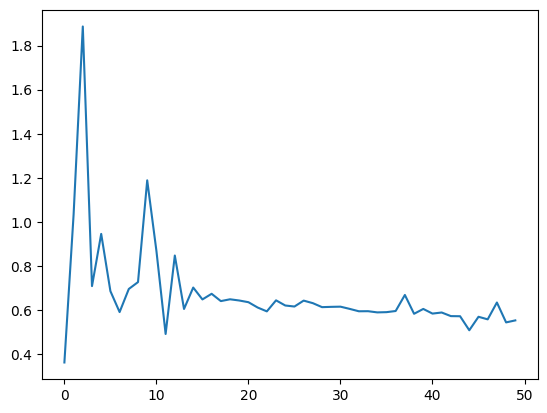

In [119]:
# in_features=2 -> number of input features per node
# hidden_features=4 -> number of hidden features per node
# out_features=2 -> number of output features per node: 2 classes so 2 output features ie 2 probabilities one for each class
# dropout=0.5 -> dropout probability
model = GCN(in_features=2, hidden_features=10, out_features=2, dropout=0.1)

# Forward pass
output = model(node_features, adj)
# print(output)

# Loss function
criterion = nn.CrossEntropyLoss()

# Compute the loss
loss = criterion(output, node_labels)
print("Loss:", loss.item())

# Perform backpropagation
loss.backward()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

losses = []

# Training loop
for epoch in range(500):
    optimizer.zero_grad()
    output = model(node_features, adj)
    loss = criterion(output, node_labels)
    loss.backward()
    optimizer.step()
    if (epoch) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")
        losses.append(loss.item())

# Test the model
output = model(node_features, adj)
predicted_labels = output.argmax(dim=1)
print("\nPredicted labels:", predicted_labels.numpy())
print("True labels:", node_labels.numpy())
print("Accuracy:", torch.sum(node_labels == predicted_labels).item() / len(node_labels))

plt.plot(losses)